## The Process
### 1. visualize the data
### 2. stationarize the time series
### 3. plot ACF/PACF
### 4. build the ARIMA
### 5. make the prediction

### reference: http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [4]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]


# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


## First use the last 365 days as test set

In [5]:
from statsmodels.tsa.stattools import adfuller
df = y.copy()
df['y']=y.values
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30,center=False).mean()
    rolstd = timeseries.rolling(window=30,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

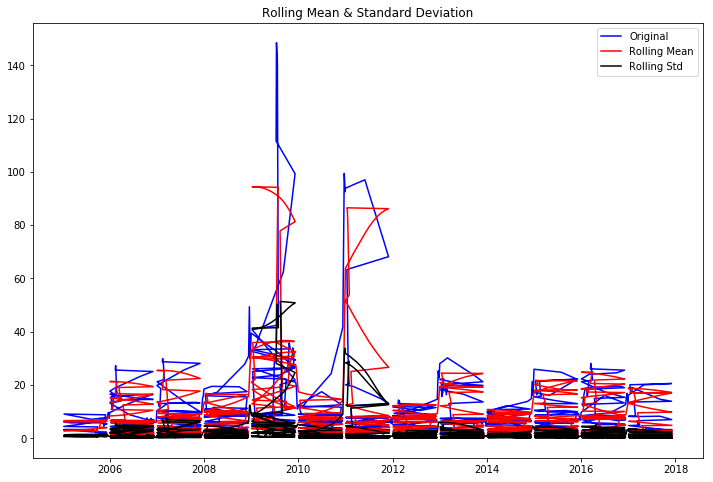

Results of Dickey-Fuller Test:
Test Statistic                -7.356968e+00
p-value                        9.722981e-11
#Lags Used                     3.100000e+01
Number of Observations Used    4.351000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [6]:
test_stationarity(df.y)

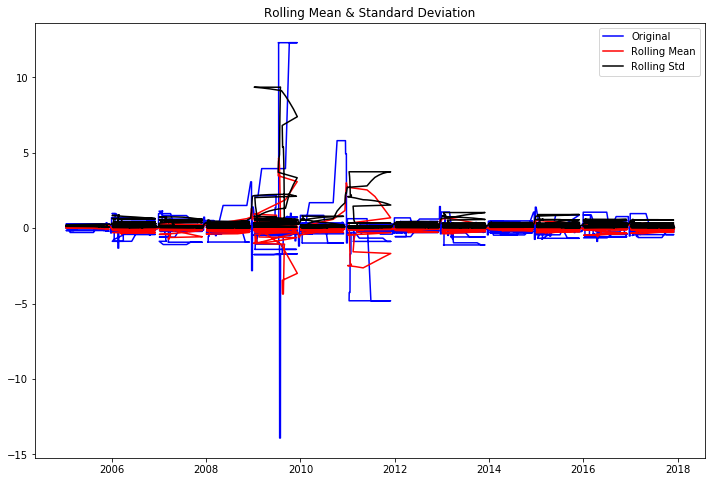

Results of Dickey-Fuller Test:
Test Statistic                -1.294262e+01
p-value                        3.508763e-24
#Lags Used                     3.100000e+01
Number of Observations Used    4.350000e+03
Critical Value (1%)           -3.431854e+00
Critical Value (5%)           -2.862205e+00
Critical Value (10%)          -2.567124e+00
dtype: float64


In [7]:
# take a first difference of the data, remove the overall trend
df['first_dif'] = df.y-df.y.shift(1)
test_stationarity(df.first_dif.dropna(inplace=False))

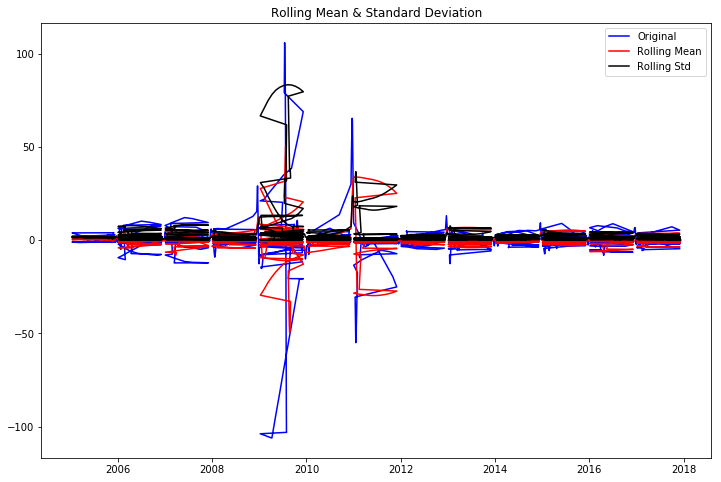

Results of Dickey-Fuller Test:
Test Statistic                -1.161143e+01
p-value                        2.507599e-21
#Lags Used                     3.100000e+01
Number of Observations Used    4.339000e+03
Critical Value (1%)           -3.431858e+00
Critical Value (5%)           -2.862206e+00
Critical Value (10%)          -2.567125e+00
dtype: float64


In [8]:
# remove the seasonality
df['seasonal_dif'] = df.y-df.y.shift(12)
test_stationarity(df.seasonal_dif.dropna(inplace=False))

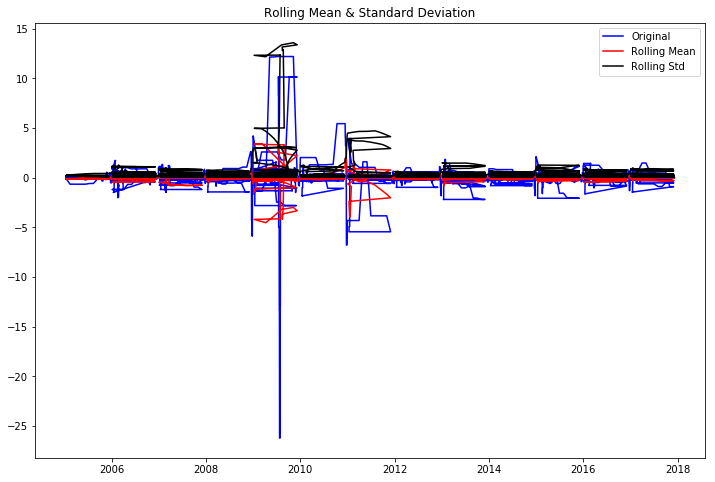

Results of Dickey-Fuller Test:
Test Statistic                -1.765380e+01
p-value                        3.709482e-30
#Lags Used                     3.000000e+01
Number of Observations Used    4.339000e+03
Critical Value (1%)           -3.431858e+00
Critical Value (5%)           -2.862206e+00
Critical Value (10%)          -2.567125e+00
dtype: float64


In [9]:
# take a first difference of seasonal difference
df['seasonal_first_dif'] = df.first_dif - df.first_dif.shift(12)
test_stationarity(df.seasonal_first_dif.dropna(inplace=False))

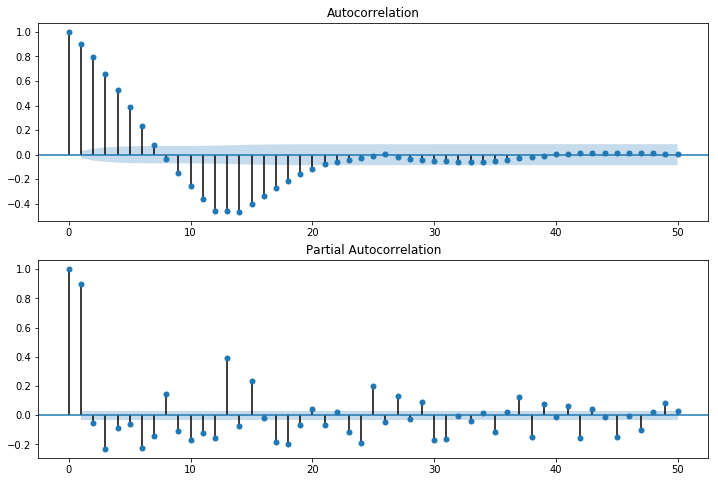

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_dif.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_dif.iloc[13:], lags=50, ax=ax2)

In [11]:
# the 3 queries 
df3 = train1_X2.iloc[:, 0: 3].copy()
df4 = test1_X.iloc[:,0:3].copy()


In [12]:
p_values = [0,1]
d_values = [1,2]
q_values = [13,14]
P_v=[0,1]
D_v=[0,1]
Q_v=[0,1]
s_v=[0,7,12]
train = train2_y2.values
best_score=1000000000
p0=0
d0=0
q0=0
P0=0
D0=0
Q0=0
s0=0
param_best=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_v:
                for D in D_v:
                    for Q in Q_v:
                        for s in s_v:
                            try:
                                model = sm.tsa.statespace.SARIMAX(train,
                                                                  trend='n', order=(p,d,q),
                                                                  seasonal_order=(P,D,Q,s),
                                                                  enforce_stationarity=False,
                                                                  enforce_invertibility=False)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                print('(',p,',',d,',',q,'),(',P,',',D,',',Q,',',s,') AIC:',aic)
                                
                                if aic < best_score:
                                    best_score = aic
                                    param_best = model_fit().params
                                    p0=p
                                    d0=d
                                    q0=q
                                    P0=P
                                    D0=D
                                    Q0=Q
                                    s0=s
                                
                            except:
                                continue
print('Best SARIMA (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
print(param_best)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 3118.701267403387


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 3118.701267403387


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 3118.701267403387


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 3133.908898428398


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 3134.4172520831344


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 3133.2897582873325
( 0 , 1 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 4380.7489853170055


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 5245.523343465945


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 3538.3238907921395


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 3421.1554448223787


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 3138.5392661315855


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 3085.0303823855775


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 3121.2060186584395


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 3134.280185364616


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3035.0986609896954


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 3125.5823811030214


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 4452.53533585893


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 4987.769284047497


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 4442.441122130259


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 3560.0257666708067


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3126.6378560638223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3126.6378560638223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3126.6378560638223


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3122.9090358080057


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3117.612261664884


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3139.052374831077


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 4393.265770815078


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 4999.859479822966


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 3434.87207882266


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 3244.8372333572065


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3119.3328518850103


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3113.5452354756267


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3129.9250032242626


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3123.7369224220674


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 3056.914300300516


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3137.252285982483
( 0 , 1 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 4377.170021346998


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 4807.748676041069


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3493.1863187194544


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 1 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 3367.6478821023047
( 0 , 2 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 3583.6094565052763
( 0 , 2 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 3583.6094565052763
( 0 , 2 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 3583.6094565052763
( 0 , 2 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 3585.624209587049
( 0 , 2 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 3123.0774391505647
( 0 , 2 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 3585.8589886169975
( 0 , 2 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 4953.14159079783


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 4958.820100736922
( 0 , 2 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 3682.7168775655036


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 3641.7826556646914
( 0 , 2 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 3585.6094991290015
( 0 , 2 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 3310.2992774552413
( 0 , 2 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 3585.6094654555786


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 3187.3852277935357
( 0 , 2 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3052.7613722622555
( 0 , 2 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 3587.8589946655175
( 0 , 2 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 4789.742957163181


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 4967.143302894275
( 0 , 2 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 3408.24901457314


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 3652.0832614226165
( 0 , 2 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3122.173368633661
( 0 , 2 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3122.173368633661
( 0 , 2 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3122.173368633661
( 0 , 2 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3124.3317149404097
( 0 , 2 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3037.4440590809227
( 0 , 2 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3125.9840850117057
( 0 , 2 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 3671.129797276936


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 4960.52573165757
( 0 , 2 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 3219.1736132711776


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 3178.784060031084
( 0 , 2 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3124.1733637293783
( 0 , 2 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3051.7486527619517
( 0 , 2 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3124.17336401343


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3124.8828820057115
( 0 , 2 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 2766.081226078898
( 0 , 2 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3127.9840847276064


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 3397.998172128638


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 4489.78957876564
( 0 , 2 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3148.8036767873045


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 3180.7627818050623


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 3119.0606693765203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 3119.0606693765203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 3119.0606693765203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 3333.672956427302


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 3096.35592726064


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 3254.3036576893264


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 4215.310163077909


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 4762.34443397797


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 3647.7388582905205


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 3812.6057180251764


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 3380.2797649345976


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 3296.9692027521824


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 3149.33427786387


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 3185.5723729994625


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3062.602144727047


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 3139.4454232115177


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 4581.163207146369


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 4774.31051643144


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 3354.5138031658403


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 4760.466865658949
( 1 , 1 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3061.7319104068238
( 1 , 1 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3061.7319104068238
( 1 , 1 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3061.7319104068238


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3062.771309825752
( 1 , 1 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 2993.438557678153


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3063.9845446888653


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 4072.2755707053193


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 4738.438257250176


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 3158.846210203028


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 3118.8934531058585


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3124.520132542708
( 1 , 1 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3002.0911687381936
( 1 , 1 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3062.0395124887677


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3066.1883787338206


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 2767.323014117664


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3066.657916601433


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 3990.650245520527


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 4315.615416751562


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3099.240798920125


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 1 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 3119.941332602992
( 1 , 2 , 13 ),( 0 , 0 , 0 , 0 ) AIC: 3585.609455058864
( 1 , 2 , 13 ),( 0 , 0 , 0 , 7 ) AIC: 3585.609455058864
( 1 , 2 , 13 ),( 0 , 0 , 0 , 12 ) AIC: 3585.609455058864
( 1 , 2 , 13 ),( 0 , 0 , 1 , 0 ) AIC: 3587.6242162227786
( 1 , 2 , 13 ),( 0 , 0 , 1 , 7 ) AIC: 3125.0775130534876
( 1 , 2 , 13 ),( 0 , 0 , 1 , 12 ) AIC: 3587.8589961373873
( 1 , 2 , 13 ),( 0 , 1 , 0 , 7 ) AIC: 4955.141590773056


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 0 , 1 , 0 , 12 ) AIC: 4960.893000928385


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 0 , 1 , 1 , 7 ) AIC: 3646.648628377078


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 0 , 1 , 1 , 12 ) AIC: 3590.560027109756
( 1 , 2 , 13 ),( 1 , 0 , 0 , 0 ) AIC: 3587.6095146320627
( 1 , 2 , 13 ),( 1 , 0 , 0 , 7 ) AIC: 3312.2992728108143
( 1 , 2 , 13 ),( 1 , 0 , 0 , 12 ) AIC: 3587.6094640251094


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 0 , 1 , 0 ) AIC: 3369.3816519504585
( 1 , 2 , 13 ),( 1 , 0 , 1 , 7 ) AIC: 3054.761362976086
( 1 , 2 , 13 ),( 1 , 0 , 1 , 12 ) AIC: 3589.85899876779
( 1 , 2 , 13 ),( 1 , 1 , 0 , 7 ) AIC: 4791.742881735741


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 1 , 0 , 12 ) AIC: 4966.54914596438


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 1 , 1 , 7 ) AIC: 3410.195592797523


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 13 ),( 1 , 1 , 1 , 12 ) AIC: 3541.443512949688
( 1 , 2 , 14 ),( 0 , 0 , 0 , 0 ) AIC: 3124.1733723869474
( 1 , 2 , 14 ),( 0 , 0 , 0 , 7 ) AIC: 3124.1733723869474
( 1 , 2 , 14 ),( 0 , 0 , 0 , 12 ) AIC: 3124.1733723869474
( 1 , 2 , 14 ),( 0 , 0 , 1 , 0 ) AIC: 3126.3317333932496
( 1 , 2 , 14 ),( 0 , 0 , 1 , 7 ) AIC: 3039.444033105831
( 1 , 2 , 14 ),( 0 , 0 , 1 , 12 ) AIC: 3127.9840817773293


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 0 , 1 , 0 , 7 ) AIC: 3678.959985035477


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 0 , 1 , 0 , 12 ) AIC: 4962.8983132446


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 0 , 1 , 1 , 7 ) AIC: 3221.1587884781948


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 0 , 1 , 1 , 12 ) AIC: 3180.8642544420545
( 1 , 2 , 14 ),( 1 , 0 , 0 , 0 ) AIC: 3126.1733730672895
( 1 , 2 , 14 ),( 1 , 0 , 0 , 7 ) AIC: 3053.748667359704
( 1 , 2 , 14 ),( 1 , 0 , 0 , 12 ) AIC: 3126.173367735203


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 1 , 0 , 1 , 0 ) AIC: 3125.836759623063


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 2768.08187901785
( 1 , 2 , 14 ),( 1 , 0 , 1 , 12 ) AIC: 3129.984081488414


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 1 , 1 , 0 , 7 ) AIC: 3423.9058285663878


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 1 , 1 , 0 , 12 ) AIC: 4492.121579090694
( 1 , 2 , 14 ),( 1 , 1 , 1 , 7 ) AIC: 3150.6822621694077


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 1 , 2 , 14 ),( 1 , 1 , 1 , 12 ) AIC: 3183.1455084474314
Best SARIMA ( 0 , 0 , 0 ),( 0 , 0 , 0 , 0 ) AIC: 2766.081226078898
[]


#### above did not print the correct final result, but I come back and find for AIC=2766.08 is (0,2,14)(1,0,1,7)

In [17]:
p_values = [0]
d_values = [2]
q_values = [14]
P_v=[1]
D_v=[0]
Q_v=[1]
s_v=[1,2,6,7,14,28]

best_score=1000000000
p0=0
d0=0
q0=0
P0=0
D0=0
Q0=0
s0=0
param=list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_v:
                for D in D_v:
                    for Q in Q_v:
                        for s in s_v:
                            try:
                                model = sm.tsa.statespace.SARIMAX(train2_y2.values,
                                                                  trend='n', order=(p,d,q),
                                                                  seasonal_order=(P,D,Q,s),
                                                                  enforce_stationarity=False,
                                                                  enforce_invertibility=False)
                                model_fit = model.fit()
                                aic = model_fit.aic
                                print('(',p,',',d,',',q,'),(',P,',',D,',',Q,',',s,') AIC:',aic)
                                if (aic < best_score):
                                    best_score = aic
                                    param = model_fit().params
                                    p0=p
                                    d0=d
                                    q0=q
                                    P0=P
                                    D0=D
                                    Q0=Q
                                    s0=s
                                    print('updated! (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
                            except:
                                continue
print('Best SARIMA (',p0,',',d0,',',q0,'),(',P0,',',D0,',',Q0,',',s0,') AIC:', best_score)
print(param)


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 1 ) AIC: 3124.8828820057115


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 2 ) AIC: 3105.6900364398853
( 0 , 2 , 14 ),( 1 , 0 , 1 , 6 ) AIC: 3127.077451580311
( 0 , 2 , 14 ),( 1 , 0 , 1 , 7 ) AIC: 2766.081226078898
( 0 , 2 , 14 ),( 1 , 0 , 1 , 14 ) AIC: 2930.011319868817


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


( 0 , 2 , 14 ),( 1 , 0 , 1 , 28 ) AIC: 3072.49918367522
Best SARIMA ( 0 , 0 , 0 ),( 0 , 0 , 0 , 0 ) AIC: 2766.081226078898
[]


In [5]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


In [13]:
train1 = train2_y2.values
test1 = test2_y.values

history = [x for x in train1]

training_mod = sm.tsa.SARIMAX(history, order=(0,2,14),
                              seasonal_order=(1,0,1,7),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
training_res = training_mod.fit()
training_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3653
Model:             SARIMAX(0, 2, 14)x(1, 0, 1, 7)   Log Likelihood               -1366.041
Date:                            Sun, 15 Jul 2018   AIC                           2766.081
Time:                                    14:57:45   BIC                           2871.425
Sample:                                         0   HQIC                          2803.608
                                           - 3653                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0025      3.706      0.001      0.999      -7.261       7.266
ma.L2         -0.0016      1.579     -0.001      0.999      -3.096       3.093
ma.L3          0.0003      6.302   4.37e-05      1.000     -12.351      12.351
ma.L4          0.0003      6.067   4.25e-05      1.000     -11.891      11.892
ma.L5         -0.0017      1.515     -0.001      0.999      -2.971       2.968
ma.L6          0.0026      3.693      0.001      0.999      -7.236       7.242
ma.L7         -0.4752      5.764     -0.082      0.934     -11.773      10.823
ma.L8          0.0012      2.014      0.001      1.000      -3.946       3.948
ma.L9         -0.0007      1.042     -0.001      0.999      -2.044       2.042
ma.L10      5.703e-05      3.425   1.67e-05      1.000      -6.712       6.712
ma.L11      2.605e-05      3.322   7.84e-06      1.000      -6.510       6.510
ma.L12        -0.0009      0.912     -0.001      0.999      -1.789       1.787
ma.L13         0.0013      1.985      0.001      0.999      -3.889       3.891
ma.L14        -0.5302      3.046     -0.174      0.862      -6.500       5.439
ar.S.L7        0.7395      0.003    211.993      0.000       0.733       0.746
ma.S.L7       -1.0073      0.180     -5.608      0.000      -1.359      -0.655
sigma2         0.1178      0.672      0.175      0.861      -1.200       1.436
===================================================================================
Ljung-Box (Q):                       29.65   Jarque-Bera (JB):          41083238.54
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            10.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
train1 = train2_y2.values
test1 = test2_y.values

history = [x for x in train1]
predict = list()

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast()
    yhat = output[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

NameError: name 'training_res' is not defined

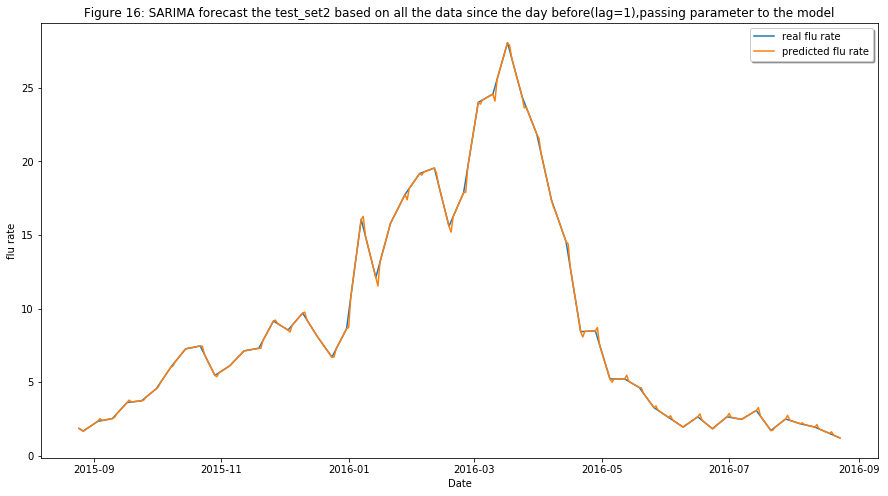

In [19]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 16: SARIMA forecast the test_set2 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
## lag=5
train1 = train2_y2.values
test = test2_y.values
test1 = test2_y[4:].values

history = [x for x in train1]
predict2 = list()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=5)
    yhat = output[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

print(mae1,rmse1)

1.838786750285046
1
1.9434042422912208
2
1.9928753020243233
3
2.1005971199711344
4
2.2849586393893837
5
2.307661295552647
6
2.5380127413017664
7
2.709598091017208
8
2.919766980559511
9
3.074298957519023
10
3.2877979138357176
11
2.5426169616144225
12
2.4970620512083466
13
2.6278296580302283
14
2.6992206674211987
15
2.8090919532570497
16
2.8642492525225935
17
2.9766490465191224
18
3.503879127435172
19
3.5873991974757145
20
3.7978441114290753
21
3.9490368506559284
22
4.138964580444338
23
4.273399151566643
24
4.466465379171097
25
3.7628852532498103
26
3.706851910879665
27
3.796392833698914
28
3.826161758288617
29
3.8946615131421813
30
3.908440644432865
31
3.9793126681280917
32
4.4827044712052295
33
4.527232686724712
34
4.7026652517406085
35
4.818464655878547
36
4.973276321466364
37
5.072612951843374
38
5.230381573768762
39
5.859342067621862
40
5.9976347146599585
41
6.122243909061668
42
6.188001405457102
43
6.293131892078348
44
6.341685199605941
45
6.450447201076156
46
7.1231894367562685
47

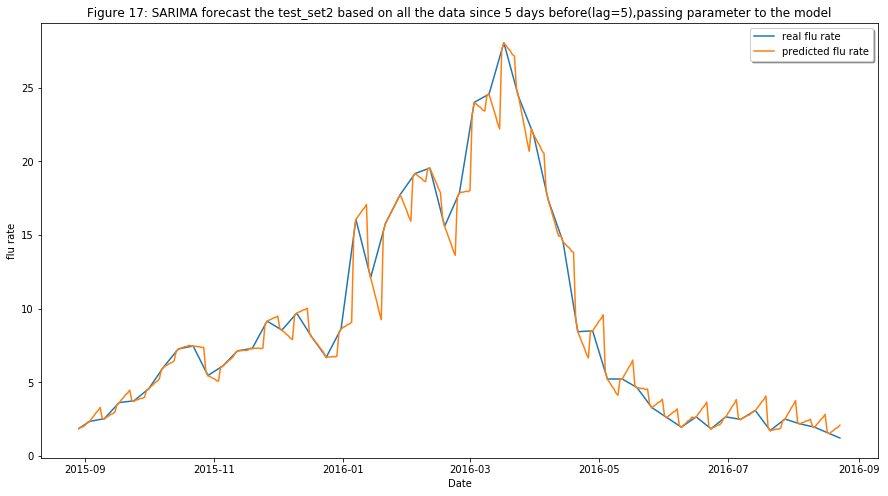

In [20]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653+4:4018],df.y[3653+4:4018],label='real flu rate')
ax.plot(date[3653+4:4018],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 17: SARIMA forecast the test_set2 based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [21]:
## lag=10
train1 = train2_y2.values
test = test2_y.values
test1 = test2_y[9:].values
history = [x for x in train1]
predict3 = list()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=10)
    yhat = output[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

print(mae1,rmse1)

2.251364869258367
1
2.469532802875534
2
2.60612915374809
3
2.8316172698018542
4
3.1478493349880563
5
3.234021525881569
6
3.4955804988154235
7
3.64917000898618
8
3.8154533145768568
9
3.8995059724751955
10
4.073534559958771
11
2.9379662134297773
12
2.9223166269219827
13
3.084815487646707
14
3.1380642963337158
15
3.320364257608404
16
3.421628468336796
17
3.610320276542643
18
4.347352530375232
19
4.412368830875405
20
4.654263026958045
21
4.787314090674234
22
4.9093016172385475
23
4.9492227924578795
24
5.078650201123225
25
3.9824597602621714
26
3.924651102658713
27
4.046107020611733
28
4.057619789870484
29
4.204055746914044
30
4.269404953360713
31
4.421972027869951
32
5.146844154903999
33
5.176025284905522
34
5.383063684064549
35
5.480603042574149
36
5.575195454934417
37
5.587694709254862
38
5.6894324601538315
39
6.415482748950599
40
6.396062664070987
41
6.551869625475994
42
6.599565569273974
43
6.654204388694119
44
6.6251438426871445
45
6.68796230315639
46
7.500189756042435
47
7.4461098351

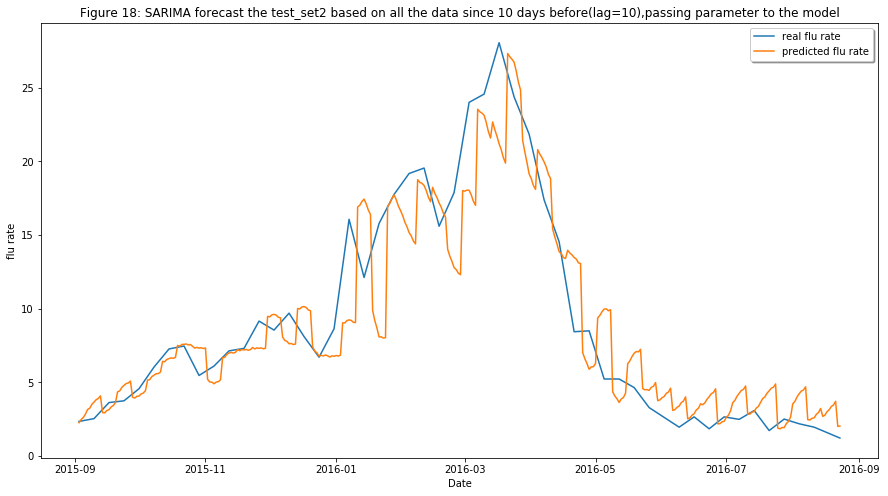

In [22]:
## lag=10
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653+9:4018],df.y[3653+9:4018],label='real flu rate')
ax.plot(date[3653+9:4018],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 18: SARIMA forecast the test_set2 based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [14]:
## lag=14
train1 = train2_y2.values
test = test2_y.values
test1 = test2_y[13:].values

history = [x for x in train1]
predict4 = list()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=14)
    yhat = output[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

print(mae1,rmse1)

2.9936764776427034
1
3.2176091290563673
2
3.3464106804237495
3
3.577941408791294
4
3.854588185508707
5
3.874019413096228
6
4.088710352850872
7
4.183308495938948
8
4.355402380347767
9
4.431609930130713
10
4.611792543172663
11
3.3605897359232384
12
3.394227177975732
13
3.6262918128999253
14
3.736714281938855
15
3.9248255317150127
16
4.018327233008815
17
4.212968154429683
18
4.949053177999543
19
4.923138359465291
20
5.094172623862881
21
5.144118466379483
22
5.271945043124052
23
5.304028752854504
24
5.439587160158971
25
4.244706850504416
26
4.241537338434045
27
4.438069061861817
28
4.512162006385101
29
4.664444696329309
30
4.722030352354403
31
4.880534320720822
32
5.615372947552317
33
5.5611988976328
34
5.7050905430088745
35
5.727148769294408
36
5.827618306226251
37
5.83228537763788
38
5.9401404779501625
39
6.693049574676207
40
6.6000101129200734
41
6.7020548990442785
42
6.683871048668413
43
6.7444125054522175
44
6.707426211267646
45
6.776519474406969
46
7.634167566851766
47
7.507818559416

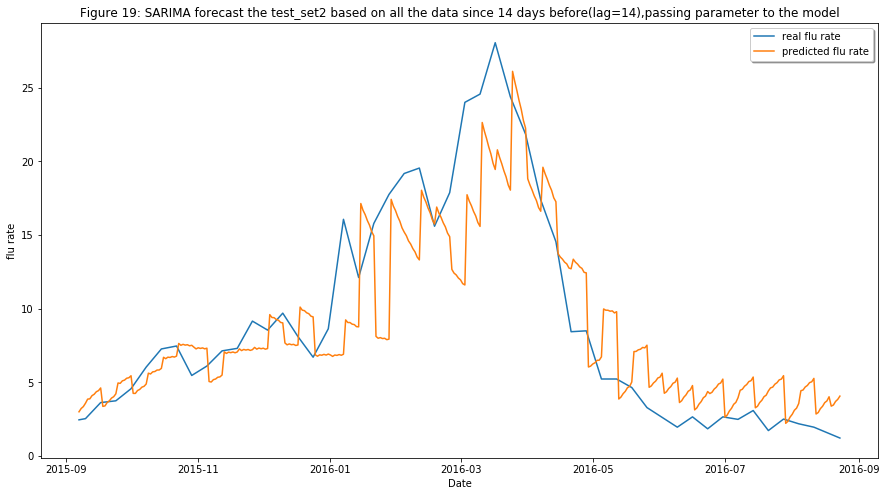

In [19]:
# visualize lag=14
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653+13:4018],df.y[3653+13:4018],label='real flu rate')
ax.plot(date[3653+13:4018],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 19: SARIMA forecast the test_set2 based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
## lag=28
train1 = train2_y2.values
test = test2_y.values
test1 = test2_y[27:].values

history = [x for x in train1]
predict5 = list()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=28)
    yhat = output[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

print(mae1,rmse1)

4.927074570277697
1
5.050077347226166
2
5.118881440733315
3
5.24621195456802
4
5.400434405950484
5
5.408124893806106
6
5.527052952932004
7
5.577564284023495
8
5.672225800020174
9
5.71226030904688
10
5.811528747746019
11
5.09501720165844
12
5.110422291541761
13
5.238864924240641
14
5.29801091414301
15
5.401415643145415
16
5.450922735477014
17
5.558046295330168
18
5.974981102562426
19
5.957850648853609
20
6.052912115733156
21
6.07899466238236
22
6.149443398735591
23
6.165350886806517
24
6.240202909900345
25
5.556645343080861
26
5.551904901048106
27
5.660919629438485
28
5.7001888948420385
29
5.783999092406231
30
5.81386573642718
31
5.901218856801147
32
6.318040018252024
33
6.2854400159696935
34
6.3656599706108645
35
6.3764815083541215
36
6.431968305404855
37
6.432883871646287
38
6.492576421397627
39
6.92060607324436
40
6.866801020870417
41
6.924113627771514
42
6.912944411682222
43
6.946617880458983
44
6.9247393195910245
45
6.963282734830766
46
7.451756204686435
47
7.379785011081783
48
7.4

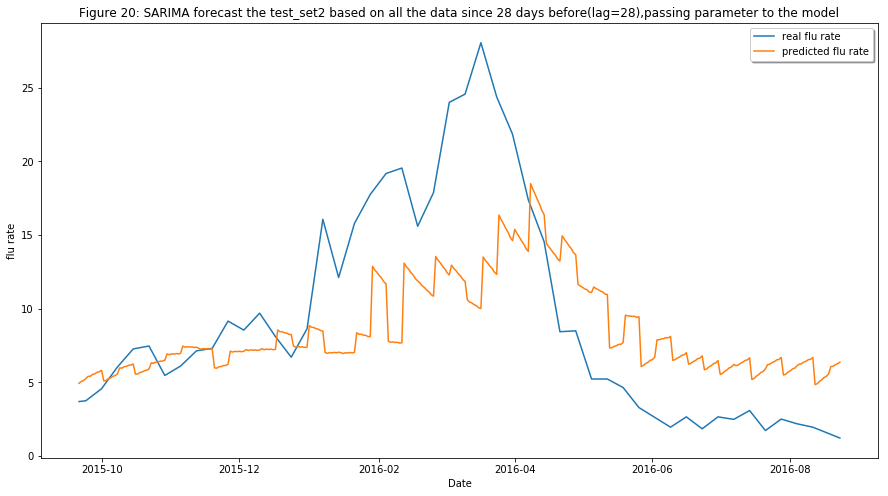

In [20]:
## lag=28
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653+27:4018],df.y[3653+27:4018],label='real flu rate')
ax.plot(date[3653+27:4018],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 20: SARIMA forecast the test_set2 based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
model = sm.tsa.SARIMAX(train2_y2.values, order=(0,2,14),seasonal_order=(1,0,1,7),enforce_stationarity=False,
                              enforce_invertibility=False)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3653
Model:             SARIMAX(0, 2, 14)x(1, 0, 1, 7)   Log Likelihood               -1366.041
Date:                            Sun, 15 Jul 2018   AIC                           2766.081
Time:                                    12:54:26   BIC                           2871.425
Sample:                                         0   HQIC                          2803.608
                                           - 3653                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0025      3.706      0.001      0.999      -7.261       7.266
ma.L2         -0.0016      1.579     -0.001      0.999      -3.096       3.093
ma.L3          0.0003      6.302   4.37e-05      1.000     -12.351      12.351
ma.L4          0.0003      6.067   4.25e-05      1.000     -11.891      11.892
ma.L5         -0.0017      1.515     -0.001      0.999      -2.971       2.968
ma.L6          0.0026      3.693      0.001      0.999      -7.236       7.242
ma.L7         -0.4752      5.764     -0.082      0.934     -11.773      10.823
ma.L8          0.0012      2.014      0.001      1.000      -3.946       3.948
ma.L9         -0.0007      1.042     -0.001      0.999      -2.044       2.042
ma.L10      5.703e-05      3.425   1.67e-05      1.000      -6.712       6.712
ma.L11      2.605e-05      3.322   7.84e-06      1.000      -6.510       6.510
ma.L12        -0.0009      0.912     -0.001      0.999      -1.789       1.787
ma.L13         0.0013      1.985      0.001      0.999      -3.889       3.891
ma.L14        -0.5302      3.046     -0.174      0.862      -6.500       5.439
ar.S.L7        0.7395      0.003    211.993      0.000       0.733       0.746
ma.S.L7       -1.0073      0.180     -5.608      0.000      -1.359      -0.655
sigma2         0.1178      0.672      0.175      0.861      -1.200       1.436
===================================================================================
Ljung-Box (Q):                       29.65   Jarque-Bera (JB):          41083238.54
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            10.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""